## Explore NY Taxi Data and Build a Simple Linear Regression model to predict trip duration

In [1]:
!python -V

Python 3.8.8


In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

/Users/rachel/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Data from NYC Taxi & Limousine Commision
Accessible via: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [3]:
df = pd.read_parquet('modelling/data/yellow_tripdata_2023-01.parquet')
print('Number of columns: ', len(df.columns))

Number of columns:  19


Standard deviation of trip durations: 42.594351241920904


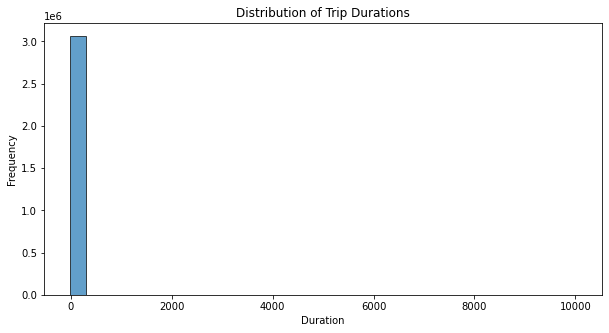

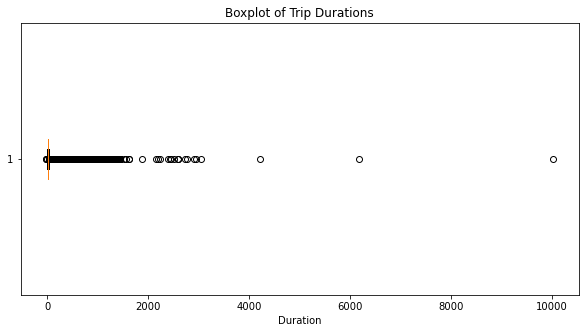

In [4]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
# Calculate the standard deviation of the 'duration' column
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
std_duration = df['duration'].std()

print(f'Standard deviation of trip durations: {std_duration}')

# Check the distribution of the duration variable. There are some outliers. 
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(df['duration'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()

# Plot boxplot
plt.figure(figsize=(10, 5))
plt.boxplot(df['duration'], vert=False)
plt.title('Boxplot of Trip Durations')
plt.xlabel('Duration')
plt.show()

In [5]:
# Keep only the records where the duration was between 1 and 60 minutes (inclusive).#
df_cleaned = df[(df.duration >= 1) & (df.duration <= 60)]

print(f'Original DataFrame shape: {df.shape}')
print(f'Cleaned DataFrame shape: {df_cleaned.shape}')
print('Percentage of records left: ', len(df_cleaned)/len(df)*100)

Original DataFrame shape: (3066766, 20)
Cleaned DataFrame shape: (3009173, 20)
Percentage of records left:  98.1220282212598


### Process data 
- Apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.
- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer and get a feature matrix

In [6]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_cleaned[categorical] = df_cleaned[categorical].astype(str)

train_dicts = df_cleaned[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_cleaned[target].values

<ipython-input-6-3d64f2d2d97e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[categorical] = df_cleaned[categorical].astype(str)


### Fit a linear regression model

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

# Calculate and print the root mean squared error
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 7.649137551399666


### Create a simple function to train, test and validate the model

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
df_train = read_dataframe('modelling/data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('modelling/data/yellow_tripdata_2023-02.parquet')
print(len(df_train), len(df_val))

3009173 2855951


In [10]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

df_train[categorical] = df_train[categorical].astype(str)
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

df_val[categorical] = df_val[categorical].astype(str)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print('RMSE:', mean_squared_error(y_val, y_pred, squared=False))

RMSE: 7.811451234564389
